In [1]:
import numpy as np
import matplotlib.pyplot as plt
import field
import spatial
import timesteppers
import scipy.sparse.linalg as spla
from scipy.integrate import trapz
from scipy import sparse
import scipy.signal as signal

from timesteppers import *

from field import *
from spatial import FiniteDifferenceUniformGrid

%matplotlib inline

In [2]:
"""        
        M = LHS.field_coeff(pt, axis=axis)
        M = M.tocsr()
        print(M.shape)
        print(bc1.field_coeff(pt).shape)
        print(LHS.field_coeff(pt, axis=axis).shape)
        M[:1,:]  = bc1.field_coeff(pt)
        M[-1:,:] = bc2.field_coeff(pt)
        M.eliminate_zeros()
        self.M = M
        
        L = LHS.field_coeff(p, axis=axis)
        L = L.tocsr()
        L[:1,:]  = bc1.field_coeff(p)
        L[-1:,:] = bc2.field_coeff(p)
        L.eliminate_zeros()
        self.L = L
        """

'        \n        M = LHS.field_coeff(pt, axis=axis)\n        M = M.tocsr()\n        print(M.shape)\n        print(bc1.field_coeff(pt).shape)\n        print(LHS.field_coeff(pt, axis=axis).shape)\n        M[:1,:]  = bc1.field_coeff(pt)\n        M[-1:,:] = bc2.field_coeff(pt)\n        M.eliminate_zeros()\n        self.M = M\n        \n        L = LHS.field_coeff(p, axis=axis)\n        L = L.tocsr()\n        L[:1,:]  = bc1.field_coeff(p)\n        L[-1:,:] = bc2.field_coeff(p)\n        L.eliminate_zeros()\n        self.L = L\n        '

In [3]:
def axslice(axis, start, stop, step=None):
    """Slice array along a specified axis."""
    if axis < 0:
        raise ValueError("`axis` must be positive")
    slicelist = [slice(None)] * axis
    slicelist.append(slice(start, stop, step))
    return tuple(slicelist)

def apply_matrix(matrix, array, axis, **kw):
    """Contract any direction of a multidimensional array with a matrix."""
    dim = len(array.shape)
    # Build Einstein signatures
    mat_sig = [dim, axis]
    arr_sig = list(range(dim))
    out_sig = list(range(dim))
    out_sig[axis] = dim
    # Handle sparse matrices
    if sparse.isspmatrix(matrix):
        matrix = matrix.toarray()
    return np.einsum(matrix, mat_sig, array, arr_sig, out_sig, **kw)

class BoundaryCondition(field.LinearOperator):

    def __init__(self, derivative_order, convergence_order, arg, value, axis=0):

        self.derivative_order = derivative_order
        self.convergence_order = convergence_order
        self.dof = self.derivative_order + self.convergence_order
        self.value = value
        self.axis = axis
        self.grid = arg.domain.grids[axis]
        if not isinstance(self.grid, field.UniformNonPeriodicGrid):
            raise ValueError("Can only apply BC's on UniformNonPeriodicGrid")
        self._build_vector()
        N = self.grid.N
        self.matrix = self.vector.reshape((1,N))
        super().__init__(arg)

    def _coeffs(self, dx, j):
        i = np.arange(self.dof)[:, None]
        j = j[None, :]
        S = 1/factorial(i)*(j*dx)**i

        b = np.zeros( self.dof )
        b[self.derivative_order] = 1.

        return np.linalg.solve(S, b)
        
    def field_coeff(self, field, axis=None):
        if axis == None:
            axis = self.axis
        if axis != self.axis:
            raise ValueError("Axis must match self.axis")
        if field == self.field:
            return self.matrix
        else:
            return 0*self.matrix
        
        
class Left(BoundaryCondition):

    def _build_vector(self):
        dx = self.grid.dx
        j = 1/2 + np.arange(self.dof)
        
        coeffs = self._coeffs(dx, j)
        
        self.vector = np.zeros(self.grid.N)
        self.vector[:self.dof] = coeffs
        
    def operate(self):
        s = axslice(self.axis, 1, None)
        BC = self.value - apply_matrix(self.matrix[:,1:], self.field.data[s], self.axis)
        BC /= self.matrix[0,0]
        s = axslice(self.axis, 0, 1)
        self.field.data[s] = BC

        
class Right(BoundaryCondition):

    def _build_vector(self):
        dx = self.grid.dx
        j = np.arange(self.dof) - self.dof + 1/2
        
        coeffs = self._coeffs(dx, j)
        
        self.vector = np.zeros(self.grid.N)
        self.vector[-self.dof:] = coeffs
        
    def operate(self):
        s = axslice(self.axis, None, -1)
        BC = self.value - apply_matrix(self.matrix[:,:-1], self.field.data[s], self.axis)
        BC /= self.matrix[0,-1]
        s = axslice(self.axis, -1, None)
        self.field.data[s] = BC

In [4]:
class DiffusionBC:
    
    def __init__(self, X, nu):
        axis = 0
        self.X = X
        u = X.field_list[0]
        self.domain = u.domain
        
        dudx2 = spatial.FiniteDifferenceUniformGrid(2, 4, u)
        
        ut = field.Field(self.domain)
        
        eq1 = ut - nu*dudx2
        
        bc1 =  Left(0, 4, u, 0)
        bc2 = Right(0, 4, u, 0)
        
        M = eq1.field_coeff(ut, axis=axis)
        M = M.tocsr()
        M[:1,:]  = bc1.field_coeff(ut)
        M[-1:,:] = bc2.field_coeff(ut)
        M.eliminate_zeros()
        self.M = M
        
        L = eq1.field_coeff(u, axis=axis)
        L = L.tocsr()
        L[:1,:]  = bc1.field_coeff(u)
        L[-1:,:] = bc2.field_coeff(u)
        L.eliminate_zeros()
        self.L = L

In [5]:
class FokkerPlanck_2D:
    
    def __init__(self, X,mu,D, spatial_order=4):
      
     
        self.X = X
        p = X.field_list[0]        
        self.domain = p.domain
        
        pt = Field(self.domain)
        
        dx=FiniteDifferenceUniformGrid(1, spatial_order, p, axis=0)
        dy=FiniteDifferenceUniformGrid(1, spatial_order, p, axis=1)
        dx2=FiniteDifferenceUniformGrid(2, spatial_order, p, axis=0)
        dy2=FiniteDifferenceUniformGrid(2, spatial_order, p, axis=1)
        
        dmux=FiniteDifferenceUniformGrid(1, spatial_order, mu, axis=0)#.operate()
        dDx2=FiniteDifferenceUniformGrid(2, spatial_order, D, axis=0)#.operate()
        dmuy=FiniteDifferenceUniformGrid(1, spatial_order, mu, axis=1)#.operate()
        dDy2=FiniteDifferenceUniformGrid(2, spatial_order, D, axis=1)#.operate()
        
        #mixed terms
        
        dxdy = FiniteDifferenceUniformGrid(1, spatial_order, dx, 1)
        dydx = FiniteDifferenceUniformGrid(1, spatial_order, dy, 0)
        
        #dDx=FiniteDifferenceUniformGrid(1, spatial_order, D, axis=0)#.operate()
        #dDy=FiniteDifferenceUniformGrid(1, spatial_order, D, axis=1)#.operate()
        
        #dDxdy = FiniteDifferenceUniformGrid(1, spatial_order, dDx, 1)
        #dDydx = FiniteDifferenceUniformGrid(1, spatial_order, dDy, 0)
        
        axis='full'
        
        LHS = pt -  D*dx2 - D*dy2 + mu* dx + mu*dy  - dDx2 + dmux - dDy2 + dmuy - D*dxdy -D* dydx
        
#        self.bc1x =  Left(0, 4, p, 0,axis=0)
#        self.bc2x = Right(0, 4, p, 0,axis=0)
#        self.bc1y =  Left(0, 4, p, 0,axis=1)
#        self.bc2y = Right(0, 4, p, 0,axis=1)
        self.M = LHS.field_coeff(pt)
        self.L = LHS.field_coeff(p)
        
        self.t = 0.
        self.iter = 0

        
    def step(self, dt):
        
#        self.bc1x.operate()
#        self.bc2x.operate()
#        self.bc1y.operate()
#        self.bc2y.operate()
        self.ts = CrankNicolson(self,axis='full')
        self.ts.step(dt)
        self.t += dt
        self.iter += 1

In [6]:
resolution = 50
alpha = .1
spatial_order = 4

grid_x = field.UniformNonPeriodicGrid(resolution,(0,2*np.pi))
grid_y = field.UniformNonPeriodicGrid(resolution,(0,2*np.pi))
domain = field.Domain((grid_x, grid_y))
x, y = domain.values()
#print(np.shape(x[0]))

p = field.Field(domain)



X = field.FieldSystem([p])
r = x-np.pi

DC = .03
mu=field.Array(domain, 0*np.ones(p.data.shape))
D=field.Array(domain, DC*np.ones(p.data.shape))

idx = resolution//2 + 1
IC = signal.unit_impulse(resolution,idx)[:,None]
p.data[:]=IC
print(p.data.shape)
p.data[:]=IC

diff = FokkerPlanck_2D(X,mu,D)

tmax = 1-1e-5

dt = alpha * domain.grids[0].dx
import time
START = time.time()
sols = []
while diff.t < tmax:
    diff.step(dt)
    sols.append(p.data[:,20])
    
END = time.time()
print("### Elapsed time1 = ",END-START) 


(50, 50)


C:\Users\Lindsey\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


### Elapsed time1 =  24.036643028259277


(50,)
(50, 1)


<function matplotlib.pyplot.plot(*args, **kwargs)>

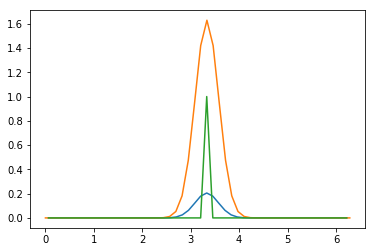

In [7]:
N = resolution
#idx = index at which the value is one (index of x0)


x_a = np.linspace(0,2*np.pi,N)
idx = N//2 + 1
Wiener_IC = signal.unit_impulse(N,idx)
x0 = x_a[idx]
t0 = 0

def Wiener_sol(D,t,t0,x,x0):
    sol = 1/(np.sqrt(4*np.pi*D*(t-t0)))*np.exp(-1*(x-x0)**2/(4*D*(t-t0)))
    return sol

target = Wiener_sol(DC,tmax,t0,x_a,x0)


print(x[:,0].shape)
print(IC.shape)
plt.plot(x[:,0],p.data[:,20])
plt.plot(x_a,target,label='target')
plt.plot(x[:,0],IC)
plt.plot

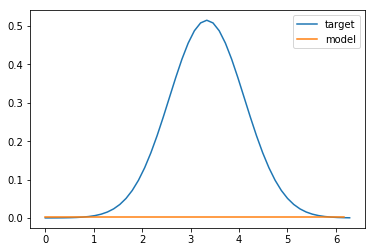

In [54]:
plt.plot(x_a,target,label='target')
#plt.plot(x_a,Wiener_IC)
plt.plot(x[:,0],p.data[:,20],label='model')
plt.legend()

In [137]:
resolution = 50
N = resolution
x_a = np.linspace(0,2*np.pi,N)
idx = N//2 + 1
x0 = x_a[idx]
gamma = 1
D = .3
mu = gamma * x_a
ou_IC = signal.unit_impulse(N,idx)
tmax = -1e-5


def ornstein_uhlenbeck_sol(gamma,D,mu,t,x,x0):
    a = np.sqrt(gamma/(2*np.pi*D*(1-np.exp(-2*gamma*(t))))) 
    b = np.exp(-1*(gamma*(x-np.exp(-gamma*t)*x0)**2)/(2*D*(1-np.exp(-2*gamma*t))))
    return a * b

target_ou = ornstein_uhlenbeck_sol(gamma,D,mu,tmax,x_a,x0)

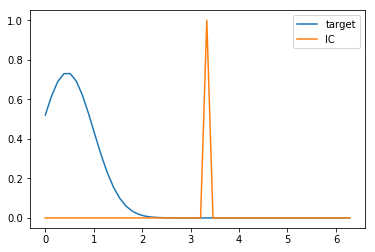

In [138]:
plt.plot(x_a,target_ou,label='target')
plt.plot(x_a,ou_IC,label='IC')
plt.legend()

In [192]:
resolution = 50
alpha = .1
spatial_order = 4

grid_x = field.UniformNonPeriodicGrid(resolution,(0,2*np.pi))
grid_y = field.UniformNonPeriodicGrid(resolution,(0,2*np.pi))
domain = field.Domain((grid_x, grid_y))
x, y = domain.values()
#print(np.shape(x[0]))

p = field.Field(domain)


X = field.FieldSystem([p])
gamma = 1
#D = .3
x2,y2 = np.meshgrid(x,x)

DC = .3

D=field.Array(domain, DC*np.ones(p.data.shape))
mu=field.Array(domain, gamma*x2)

idx = resolution//2 + 1
IC = signal.unit_impulse(resolution,idx)[:,None]
p.data[:]=IC
print(p.data.shape)

diff = FokkerPlanck_2D(X,mu,D)

tmax = 2-1e-5

dt = alpha * domain.grids[0].dx
import time
START = time.time()
sols = []
while diff.t < tmax:
    diff.step(dt)
    sols.append(p.data[:,20])
    
    
END = time.time()

N = resolution
x_a = np.linspace(0,2*np.pi,N)
idx = N//2 + 1
x0 = x_a[idx]
mu_a = gamma * x_a
ou_IC = signal.unit_impulse(N,idx)
target_ou = ornstein_uhlenbeck_sol(gamma,DC,mu_a,tmax,x_a,x0)

(50, 50)


C:\Users\Lindsey\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [ ]:
print(x[:,0].shape)
print(IC.shape)
plt.plot(x[:,0],p.data[:,20])
plt.plot(x_a,target_ou,label='target')
plt.plot(x[:,0],IC)
plt.plot

C:\Users\Lindsey\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


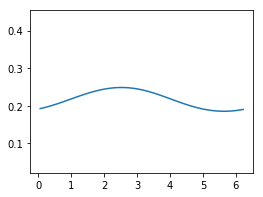

In [8]:
resolution = 50
alpha = .1
spatial_order = 4

grid_x = field.UniformNonPeriodicGrid(resolution,(0,2*np.pi))
grid_y = field.UniformNonPeriodicGrid(resolution,(0,2*np.pi))
domain = field.Domain((grid_x, grid_y))
x, y = domain.values()
#print(np.shape(x[0]))

p = field.Field(domain)

X = field.FieldSystem([p])

mu=field.Array(domain, .5*np.ones(p.data.shape))
D=field.Array(domain, .5*np.ones(p.data.shape))

diff = FokkerPlanck_2D(X,mu,D)

tmax = 2-1e-5
r = np.sqrt((x-np.pi)**2 + (y-np.pi)**2)
IC = np.exp(-r**2/4)

p.data[:]=IC
diff = FokkerPlanck_2D(X,mu,D)

output_cadence = 10
fig = plt.figure(figsize=(4,3))
#plt.ylim([-1.1,1.1])
v, = plt.plot(x[:,0], p.data[:,10])
fig.canvas.draw()
while diff.t <tmax:
    diff.step(dt)
    if diff.iter % output_cadence == 5:
        v.set_ydata(p.data[:,10])
        fig.canvas.draw()